In [63]:
#ipynb config
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
from sklearn.cross_validation import train_test_split
from models.cascade_base import CascadeBase
from utils.visualizer import Visualizer
from IPython.display import SVG, display

import numpy as np
import matplotlib.pyplot as plt

import time
import pydot
import lasagne

plt.style.use('ggplot')

%matplotlib inline

In [65]:
dataset0 = np.load('../data/not_bright/imgs_0000.npy')
targets0 = np.load('../data/not_bright/masks_0000.npy')
dataset1 = np.load('../data/not_bright/imgs_0000.npy')
targets1 = np.load('../data/not_bright/masks_0000.npy')

dataset = np.stack((dataset0, dataset1))
targets = np.stack((targets0, targets1))

track_targets = targets.copy()
track_targets[track_targets <=0] = 0

In [66]:
X_y = train_test_split(dataset.reshape(-1, 1, 512, 512).astype(np.float32),
                       track_targets.reshape(-1, 1, 512, 512).astype(np.float32))

## load pretrained on big images network

In [68]:
network = CascadeBase(img_shape=(512, 512),
                      learning_rate=1e-3,
                      c=1e-1,
                      c_complexity=5e-1,
                      c_sub_objs=[1e-2, 5e-1, 1, 1],
                      c_sub_obj_cs=[1e-2, 5e-2, 1e-1, 1e-1],
                      mul=True,
                      pool_sizes=[2, 2, 2, 2],
                      num_filters=[1, 1, 3, 6],
                      filter_sizes=[1, 3, 3, 3],
                      l2_c=1e-4)

In [69]:
network.load('../weights', '3cascades_difficult')

In [70]:
import theano
import theano.tensor as T

In [71]:
X = X_y[1][:100]
t = X_y[-1][:100]

prediction = network.predict(X)

In [72]:
get_target = theano.function([network.targets], lasagne.layers.get_output(network.target_pool_layers[-1]))

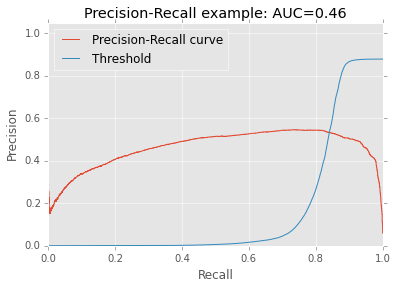

In [73]:
from sklearn.metrics import precision_recall_curve, average_precision_score

x_val = X_y[1][:100]
y_val = X_y[-1][:100]

prediction = network.predict(x_val)
target = get_target(y_val)

precision, recall, thr = precision_recall_curve(target.ravel(), prediction.ravel())
average_precision = average_precision_score(target.ravel(), prediction.ravel())

# Plot Precision-Recall curve
plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.plot(np.arange(thr.shape[0]) / (thr.shape[0] + 1e-6), thr, label='Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc='best')
plt.show()

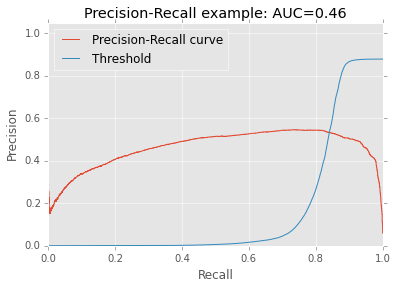

In [74]:
from sklearn.metrics import precision_recall_curve, average_precision_score

x_val = X_y[1][:100]
y_val = X_y[-1][:100]

prediction = network.predict(x_val)
target = get_target(y_val)

precision, recall, thr = precision_recall_curve(target.ravel(), prediction.ravel())
average_precision = average_precision_score(target.ravel(), prediction.ravel())

# Plot Precision-Recall curve
plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.plot(np.arange(thr.shape[0]) / (thr.shape[0] + 1e-6), thr, label='Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc='best')
plt.show()

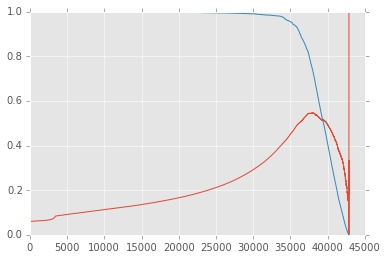

In [75]:
plt.plot(precision)
plt.plot(recall)

In [76]:
precision[30000]

0.29161479311607469

In [77]:
thr[30000]

0.045207813

In [78]:
recall[30000]

0.99005469915464939

In [138]:
complexity, max_complexity, miltipliers, constants = network.compute_complexity()
result = complexity[0] * network.input_X.shape[0]

for i in range(len(complexity) - 1):
    result += complexity[i + 1] * miltipliers[i] + 10 * constants[i]
    
estimate_complexity = theano.function([network.input_X, network.targets], result / complexity[0] / network.input_X.shape[0])

In [139]:
x_val = X_y[1][:500]
y_val = X_y[-1][:500]

estimate_complexity(x_val, y_val)

array(1.2205950927734375)

In [45]:
complexity, max_complexity, miltipliers, constants = network.compute_complexity()
result = complexity[0]
max_result = max_complexity[0]

for i in range(len(complexity) - 1):
    result += complexity[i + 1] * miltipliers[i] + constants[i]
    
estimate_complexity = theano.function([network.input_X, network.targets], result / complexity[0])

In [47]:
x_val = X_y[1][:10000]
y_val = X_y[-1][:10000]

estimate_complexity(x_val, y_val) / len(x_val)

1.8281576404571533

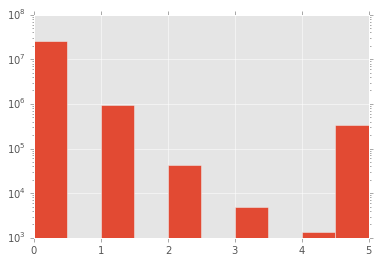

In [48]:
plt.hist(X.ravel())
plt.yscale('log')

In [54]:
sigmoid = np.vectorize(lambda x: 1.0 / (1.0 + np.exp(-x)))

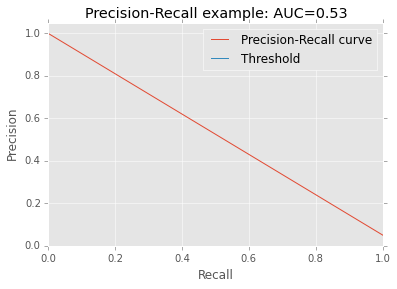

In [56]:
from sklearn.metrics import precision_recall_curve, average_precision_score

x_val = X_y[1][:100]
y_val = X_y[-1][:100]

prediction = get_target(sigmoid(x_val).astype(np.float32)).ravel()
target = get_target(y_val).ravel()

precision, recall, thr = precision_recall_curve(target.ravel(), prediction.ravel())
average_precision = average_precision_score(target.ravel(), prediction.ravel())

# Plot Precision-Recall curve
plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.plot(np.arange(thr.shape[0]) / (thr.shape[0] + 1e-6), thr, label='Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc='best')
plt.show()

In [57]:
precision

array([ 0.05026699,  1.        ])

In [53]:
recall

array([ 1.,  0.])

In [72]:
sigmoid(4)

array(0.9820137900379085)

In [73]:
thr

array([ 0.99330715])